Using 1210 days of return data (~4 years)


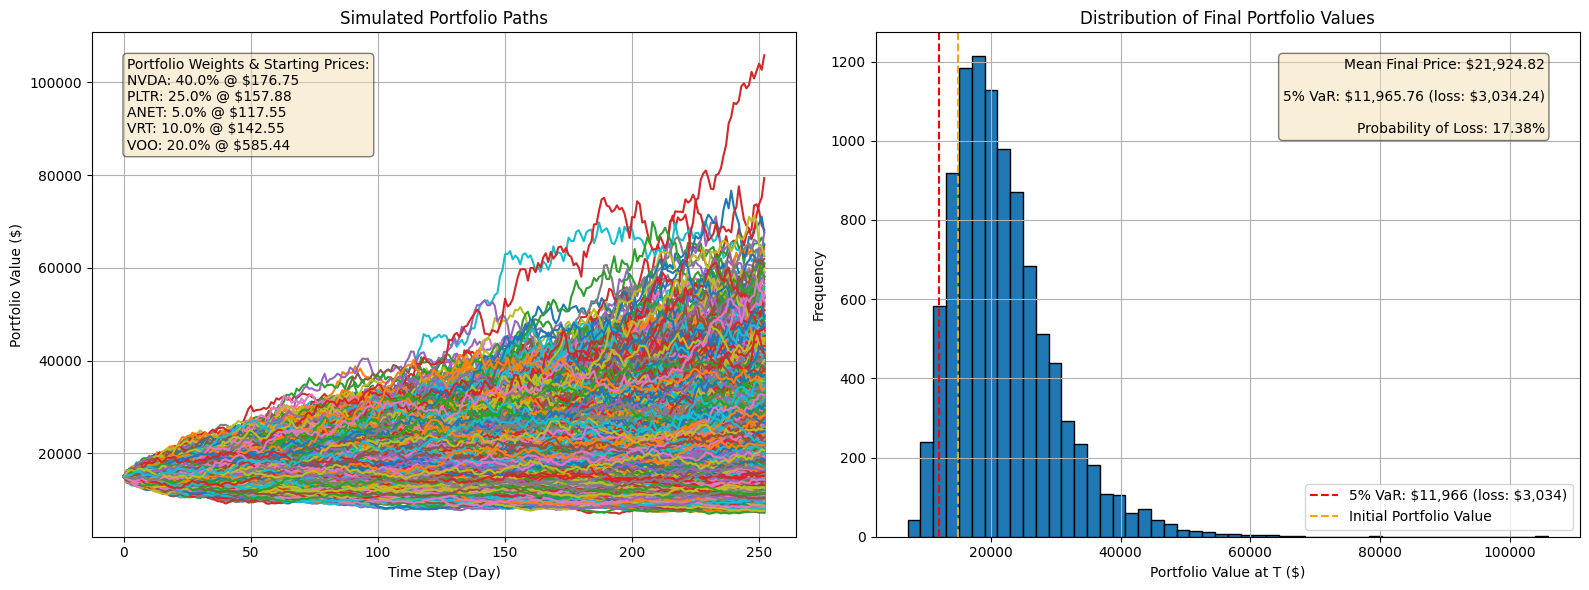

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# portfolio tickers and weights
tickers = ["NVDA", "PLTR", "ANET", "VRT", "VOO"]
weights = np.array([0.40, 0.25, 0.05, 0.10, 0.20])
n_assets = len(tickers)

# time setup
T = 1
trading_days = 252
N = trading_days
dt = T / N
M = 10000

# fetch historical closes and compute S0, mu, sigma for each asset
S0 = np.zeros(n_assets)
mu = np.zeros(n_assets)
sigma = np.zeros(n_assets)
log_returns_list = []

for i, sym in enumerate(tickers):  # 'sym' = stock symbol (e.g., "NVDA")
    hist = yf.Ticker(sym).history(period="5y")['Close']
    log_ret = np.log(hist / hist.shift(1)).dropna()
    log_returns_list.append(log_ret.values)

    S0[i] = hist.iloc[-1]
    mu[i] = log_ret.mean() * trading_days
    sigma[i] = log_ret.std() * np.sqrt(trading_days)

# align return series to the shortest available length
min_len = min(len(r) for r in log_returns_list)
log_returns_matrix = np.column_stack([r[-min_len:] for r in log_returns_list])

print(f"Using {min_len} days of return data (~{min_len // 252} years)")

# dynamically compute correlation and covariance matrices
corr_matrix = np.corrcoef(log_returns_matrix.T)
cov_matrix = np.outer(sigma, sigma) * corr_matrix
L = np.linalg.cholesky(cov_matrix)

# simulate GBM paths
price_paths = np.zeros((M, N+1, n_assets))
price_paths[:, 0, :] = S0

for m in range(M):
    Z = np.random.normal(size=(N, n_assets))
    shocks = Z @ L.T
    for t in range(1, N+1):
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = np.sqrt(dt) * shocks[t-1]
        price_paths[m, t, :] = price_paths[m, t-1, :] * np.exp(drift + diffusion)

# compute portfolio values and scale to $15,000 initial
portfolio_values = price_paths.dot(weights)
initial_val = S0.dot(weights)
portfolio_values *= (15_000 / initial_val)

# extract final values and compute stats
final_values = portfolio_values[:, -1]
mean_final = np.mean(final_values)
VaR_95 = np.percentile(final_values, 5)
prob_loss = np.mean(final_values < 15_000)

# plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# ---- Left: Simulation Paths ----
for i in range(M):
    axs[0].plot(portfolio_values[i])

axs[0].set_title("Simulated Portfolio Paths")
axs[0].set_xlabel("Time Step (Day)")
axs[0].set_ylabel("Portfolio Value ($)")
axs[0].grid(True)

weights_percent = weights * 100
textstr = '\n'.join((
    "Portfolio Weights & Starting Prices:",
    *(f"{tickers[i]}: {weights_percent[i]:.1f}% @ ${S0[i]:.2f}" for i in range(n_assets))
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[0].text(0.05, 0.95, textstr, transform=axs[0].transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

# ---- Right: Histogram ----
axs[1].hist(final_values, bins=50, edgecolor='black')
axs[1].set_title("Distribution of Final Portfolio Values")
axs[1].set_xlabel("Portfolio Value at T ($)")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

axs[1].axvline(VaR_95, color='r', linestyle='--', label=f'5% VaR: ${VaR_95:,.0f} (loss: \\${15_000 - VaR_95:,.0f})')
axs[1].axvline(15_000, color='orange', linestyle='--', label='Initial Portfolio Value')
axs[1].legend()

textstr2 = (
    f"Mean Final Price: ${mean_final:,.2f}\n\n"
    f"5% VaR: ${VaR_95:,.2f} (loss: \\${15_000 - VaR_95:,.2f})\n\n"
    f"Probability of Loss: {prob_loss:.2%}"
)
axs[1].text(0.95, 0.95, textstr2, transform=axs[1].transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()
